In [4]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import torchvision

import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam,Adagrad

import torch.nn.functional as F
from PIL import Image 

from MiraBest import MiraBest
from FRDEEP import FRDEEPF

import matplotlib.pyplot as plt

from torchvision.utils import save_image

In [44]:
import collections

In [5]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [6]:
smoke_test = 'CI' in os.environ

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # conv1 output width: input_width - (kernel_size - 1) => 150 - (5-1) = 146
        # pool 1 output width: int(input_width/2) => 73
        x = self.pool(F.relu(self.conv1(x)))
        # conv2 output width: input_width - (kernel_size - 1) => 73 - (5-1) = 69
        # pool 2 output width: int(input_width/2) => 34
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 16 * 34 * 34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def classification_procedure():
    
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

    trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
    batch_size_train = 2
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

    testset = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=transform) 
    batch_size_test = 2
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

    classes = ('FRI', 'FRII')

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    net = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer2 = optim.Adagrad(net.parameters(), lr=0.01)

    nepoch = 50  # number of epochs
    print_num = 50
    for epoch in range(nepoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer2.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer2.step()

            # print statistics
            running_loss += loss.item()
            if i % print_num == (print_num-1):    # print every 50 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / print_num))
                running_loss = 0.0

    print('Finished Training')

    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50 test images: %d %%' % (100 * correct / total))

    return net

In [9]:
#--------------------Download FIRST Images using either MiraBest or FRDEEP------------------------------------------
def dataloader_first():
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

    trainset = MiraBest(root='./FIRST_data', train=True, download=True, transform=transform)  
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))
    
    classes = ('FRI', 'FRII') #First class if FR1 and second class is FR2
    
    array_train= next(iter(trainloader))[0].numpy() # Training Datasets is loaded in numpy array
    array_label= next(iter(trainloader))[1].numpy()
    
    augmented_data=np.zeros((len(array_train)*36,1,100,100))
    
    augmented_data_label = np.zeros((len(array_train)*36,1))
    
    count=0
    
    for j in range(0,len(array_train)):
        image_object=Image.fromarray(array_train[j,0,:,:])
        for i in range(0,36):
            rotated=image_object.rotate(i*10)
            imgarr = np.array(rotated)
            temp_img_array=imgarr[25:125,25:125]
            augmented_data[count,0,:,:]=temp_img_array
            augmented_data_label[count,:]=array_label[j]
            count+=1
    augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))
    
    X=augmented_data
    Y=augmented_data_label
    
    X_random_mix=np.take(X,np.random.RandomState(seed=42).permutation(X.shape[0]),axis=0,out=X)
    Y_random_mix=np.take(Y,np.random.RandomState(seed=42).permutation(Y.shape[0]),axis=0,out=Y)
    
    tensor_x = torch.stack([torch.Tensor(i) for i in X_random_mix])
    tensor_y = torch.stack([torch.Tensor(i) for i in Y_random_mix])
    
    first_augmented_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    
    first_dataloader = torch.utils.data.DataLoader(first_augmented_dataset,batch_size=100, shuffle=True) # create your dataloader
    
    #--------------------------------------Add Section for Test data------------------------------------
    
    # Cropping of the Testing Images to 100 by 100 pixels
    
    
    testset = MiraBest(root='./FIRST_data', train=False, download=True, transform=transform) 
    
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size=len(testset))

    array_test= next(iter(testloader))[0].numpy()
    
    test_labels = next(iter(testloader))[1].numpy()
    
    test_data_reduced=np.zeros((len(array_test),1,100,100))
    test_data_label = np.zeros((len(array_test),1))
    
    for k in range (0,len(array_test)):
        test_data_reduced[k][0][:][:] = array_test[k][0][25:125,25:125]
        test_data_label[k,:]=test_labels[k]
    
    test_data_reduced=(test_data_reduced-np.min(test_data_reduced))/(np.max(test_data_reduced)-np.min(test_data_reduced))
    
    
    
    tensor_test = torch.stack([torch.Tensor(i) for i in test_data_reduced])
    tensor_test_label = torch.stack([torch.Tensor(i) for i in test_data_label])
    
    first_augmented_dataset_test = torch.utils.data.TensorDataset(tensor_test,tensor_test_label) # create your datset
    
    first_dataloader_test = torch.utils.data.DataLoader(first_augmented_dataset_test,batch_size=50, shuffle=True) # create your dataloader
    
    return first_dataloader,first_dataloader_test

#

In [10]:
#-----------------------------------Encoder Z Network- Encodes the images to the z latent space --------------------------
class EncoderZ(nn.Module):
    #def __init__(self, z_dim, hidden_dim):
    def __init__(self, x_dim, y_dim, h_dim1, z_dim):
        super(EncoderZ, self).__init__()
        self.fc1 = nn.Linear(x_dim+y_dim, h_dim1) # x_dim=10000 + y_dim=2 to h_dim1=500
        self.fc21 = nn.Linear(h_dim1, z_dim) #h_dim5=500 to z_dim=2
        self.fc22 = nn.Linear(h_dim1, z_dim) #h_dim5=500 to z_dim=2
        self.softplus = nn.Softplus()

    def forward(self, x_y_2):
        [x,y]=x_y_2
        
        x = x.reshape(-1, 10000) 
        y = y.reshape(-1, 2) 
        
        x_y_1 = torch.cat((x,y), dim=1) 
        x_y_1 = x_y_1.view(x_y_1.size(0), -1)
        
        slope_param=0.0001
        
        # then compute the hidden units
        # We use fully connected layers
        hidden = self.softplus(self.fc1(x_y_1))
        
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden)) # mu, log_var
        
        
        return z_loc, z_scale

In [11]:
#-----------------------------------Encoder Z Network- Encodes the images to the z latent space --------------------------
class Decoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim1, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc3 = nn.Linear(z_dim+y_dim, h_dim1) #z_dim=2 to h_dim5=500
        self.fc4 = nn.Linear(h_dim1, x_dim)  #h_dim1=4096 to x_dim=10000
        
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self,z_y_2):
        # define the forward computation on the latent z
        # first compute the hidden units
        
        [z,y]=z_y_2
        
        z = z.reshape(-1, 2) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 2)
        z_y_1 = torch.cat((z,y), dim=1)
        z_y_1 = z_y_1.view(z_y_1.size(0), -1)
        
        slope_param=0.0001
        hidden = F.leaky_relu(self.fc3(z_y_1),slope_param)
        loc_img = self.sigmoid(self.fc4(hidden))
        return loc_img


In [12]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim=10000, y_dim=2, h_dim1=500, z_dim=2, use_cuda=True):
        super(VAE, self).__init__()
    
        # create the encoder and decoder networks
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
              
        self.encoder_z = EncoderZ(x_dim, y_dim, h_dim1, z_dim)
        
        self.decoder = Decoder(x_dim, y_dim, h_dim1, z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
            
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.output_size = y_dim
        
        
    # define the model p(x|z)p(z)
    def model(self, xs, ys):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)
        batch_size = xs.size(0)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)
            
            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            
    def guide(self, xs, ys):
        with pyro.plate("data"):
           # if the class label (the digit) is not supervised, sample
           # (and score) the digit with the variational distribution
           # q(y|x) = categorical(alpha(x))
           
            #-------------------REMOVED THIS PART FOR THE CLASSIFIER ASSUME ALL DATA ARE LABELLED---------

           # sample (and score) the latent handwriting-style with the variational
           # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
           loc, scale = self.encoder_z.forward([xs, ys])
           pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, xs, ys):
        # encode image x
        z_loc, z_scale = self.encoder_z.forward([xs,ys])
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder.forward([zs,ys])
        
        return loc_img


In [13]:
def train(svi, train_loader, use_cuda=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        labels_y = torch.tensor(np.zeros((y.shape[0],2)))
        y_2=torch.Tensor.cpu(y.reshape(1,y.size()[0])[0]).numpy().astype(int)  
        labels_y=np.eye(2)[y_2]
        labels_y = torch.from_numpy(labels_y)   
         
        epoch_loss += svi.step(x.reshape(-1,10000),labels_y.cuda().float())

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [14]:
def evaluate(svi, test_loader, use_cuda=True):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x,y in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x) #Data entry point <---------------------------------Data Entry Point
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test



In [15]:
def image_sample_plotter(epoch):
    with torch.no_grad():
        count = 0
        z_fr1 = z_fr2 = torch.randn(100, 2)
        labels_y1 = torch.tensor(np.zeros((100,2)))
        labels_y2 = torch.tensor(np.zeros((100,2)))
        for i in range (0,10):
            for j in range (0,10):
                z_fr1[count,0] = z_fr2[count,0] = np.random.uniform(-1,1)
                z_fr1[count,1] = z_fr2[count,1] = np.random.uniform(-1,1)
                labels_y1[count,0] = 1
                labels_y2[count,1] = 1
                count = count +1 
        
        sample1 = vae.decoder([z_fr1.cuda(),labels_y1.cuda().float()])
    
        save_image(sample1.view(100, 1, 100, 100), 'fr1_sample_2_z_space_' +str(epoch)+'.png',nrow=10)
    
        sample2 = vae.decoder([z_fr2.cuda(),labels_y2.cuda().float()])

        save_image(sample2.view(100, 1, 100, 100), 'fr2_sample_2_z_space_' +str(epoch)+'.png',nrow=10) 

In [36]:
def load_checkpoint(epoch):
    #print("loading model from ...")
    vae.load_state_dict(torch.load('/raid/scratch/davidb/1_DEVELOPMENT/VAE_FIRST/models/file_conf00x3_semi_supervised_vae_FRDEEP_epoch_'+str(epoch)))
   # print("loading optimizer states from ...")
    optimizer.load('/raid/scratch/davidb/1_DEVELOPMENT/VAE_FIRST/models/file_conf00x3_semi_supervised_vae_FRDEEP_epoch_'+str(epoch)+'_opt')
   # print("done loading model and optimizer states.")

In [17]:
def save_checkpoint(epoch):
    print("saving model to ...")
    torch.save(vae.state_dict(), '/raid/scratch/davidb/1_DEVELOPMENT/VAE_FIRST/models/file_conf00x3_semi_supervised_vae_FRDEEP_epoch_'+str(epoch))
    print("saving optimizer states...")
    optimizer.save('/raid/scratch/davidb/1_DEVELOPMENT/VAE_FIRST/models/file_conf00x3_semi_supervised_vae_FRDEEP_epoch_'+str(epoch)+'_opt')
    print("done saving model and optimizer checkpoints to disk.")


In [18]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 20000
TEST_FREQUENCY = 5

In [19]:
results_array=np.zeros((1,2))

results_array_temp=np.zeros((1,2))

results_array_test=np.zeros((1,2))

results_array_temp_test=np.zeros((1,2))

In [20]:
train_loader,test_loader = dataloader_first()
# clear param store
pyro.clear_param_store()


Files already downloaded and verified
Files already downloaded and verified


In [21]:
# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

In [22]:
# setup the optimizer
adagrad_params = {"lr": 0.001}
optimizer = Adagrad(adagrad_params)

In [23]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [25]:
load_checkpoint(3500)

loading model from ...
loading optimizer states from ...
done loading model and optimizer states.


In [41]:
net = classification_procedure()

Files already downloaded and verified
Files already downloaded and verified
[1,    50] loss: 1.004
[1,   100] loss: 0.719
[1,   150] loss: 0.709
[1,   200] loss: 0.698
[1,   250] loss: 0.691
[2,    50] loss: 0.702
[2,   100] loss: 0.671
[2,   150] loss: 0.661
[2,   200] loss: 0.590
[2,   250] loss: 0.549
[3,    50] loss: 0.561
[3,   100] loss: 0.544
[3,   150] loss: 0.517
[3,   200] loss: 0.456
[3,   250] loss: 0.547
[4,    50] loss: 0.419
[4,   100] loss: 0.535
[4,   150] loss: 0.366
[4,   200] loss: 0.665
[4,   250] loss: 0.435
[5,    50] loss: 0.434
[5,   100] loss: 0.372
[5,   150] loss: 0.377
[5,   200] loss: 0.309
[5,   250] loss: 0.399
[6,    50] loss: 0.366
[6,   100] loss: 0.347
[6,   150] loss: 0.256
[6,   200] loss: 0.389
[6,   250] loss: 0.244
[7,    50] loss: 0.284
[7,   100] loss: 0.251
[7,   150] loss: 0.208
[7,   200] loss: 0.258
[7,   250] loss: 0.298
[8,    50] loss: 0.216
[8,   100] loss: 0.201
[8,   150] loss: 0.180
[8,   200] loss: 0.178
[8,   250] loss: 0.279
[9, 

In [52]:
train_elbo = []
test_elbo = []
# training loop
for epoch in [2000,2000]:
    
    load_checkpoint(epoch)
    
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    
    
    train_loss = 0.
    for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
            # compute ELBO estimate and accumulate loss
        labels_y = torch.tensor(np.zeros((y.shape[0],2)))
        y_2=torch.Tensor.cpu(y.reshape(1,y.size()[0])[0]).numpy().astype(int)  
        labels_y=np.eye(2)[y_2]
        labels_y = torch.from_numpy(labels_y)
        
        train_loss += svi.evaluate_loss(x.reshape(-1,10000),labels_y.cuda().float()) 
            
            
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = train_loss / normalizer_train
        
    
    
    train_elbo.append(-total_epoch_loss_train)
    
    

    test_loss = 0.
        # compute the loss over the entire test set
    for x_test,y_test in test_loader:

            x_test = x_test.cuda()
            y_test = y_test.cuda()
            # compute ELBO estimate and accumulate loss
            labels_y_test = torch.tensor(np.zeros((y_test.shape[0],2)))
            y_test_2=torch.Tensor.cpu(y_test.reshape(1,y_test.size()[0])[0]).numpy().astype(int)  
            labels_y_test=np.eye(2)[y_test_2]
            labels_y_test = torch.from_numpy(labels_y_test)
        
            test_loss += svi.evaluate_loss(x_test.reshape(-1,10000),labels_y_test.cuda().float()) 
            
            
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    
    z_fr1 = z_fr2 = torch.FloatTensor(100, 2).uniform_(-2, 2)
    labels_y1 = torch.tensor(np.zeros((100,2)))
    labels_y2 = torch.tensor(np.zeros((100,2)))
        
    labels_y1[:,1] = 0
    labels_y2[:,1] = 0

    labels_y1[:,0] = 0
    labels_y2[:,0] = 0

    labels_y1[:,1] = 1
    labels_y2[:,0] = 1

    sample_fr1 = vae.decoder([z_fr1.cuda(),labels_y1.cuda().float()])
    img1=sample_fr1.reshape(100,100,100).cpu().detach().numpy()
 

    sample_fr2 = vae.decoder([z_fr2.cuda(),labels_y2.cuda().float()])
    img2=sample_fr2.reshape(100,100,100).cpu().detach().numpy()

    classification_results = np.zeros((1,100))
    
    array_fr1 = np.zeros(100)
    array_fr2 = np.zeros(100)
    for i in range (0,100):
        img_tensor = torch.tensor(np.zeros((1,1,150,150)))
        img_tensor[0,0,25:125,25:125]=sample_fr2[i].reshape(100,100)
        outputs = net(img_tensor.float())
        _, predicted = torch.max(outputs, 1)

        array_fr2[i]= float(predicted[0].cpu().detach().numpy())

        img_tensor = torch.tensor(np.zeros((1,1,150,150)))
        img_tensor[0,0,25:125,25:125]=sample_fr1[i].reshape(100,100)
        outputs = net(img_tensor.float())
        _, predicted = torch.max(outputs, 1)
    
        array_fr1[i]= float(predicted[0].cpu().detach().numpy())   
    
    print('Train Loss: '+str(total_epoch_loss_train)+' Test Loss:'+str(total_epoch_loss_test)+'VAE Efficiency:'+str((collections.Counter(array_fr1)[1]+collections.Counter(array_fr2)[0])/200))
        
    '''
        
        image_sample_plotter(epoch)
        
        results_array_temp_test[0,:][0] = epoch
        results_array_temp_test[0,:][1] = total_epoch_loss_test
        results_array_test=np.vstack((results_array_test,results_array_temp_test))
        print("    [epoch %03d]  average testing loss: %.4f" % (epoch, total_epoch_loss_test))
        
        
        
        #-------INSERT PROCEDURE FOR GENERATION AND TESTING OF CLASSIFIER--------
        z_fr1 = z_fr2 = torch.randn(100, 2)
        labels_y1 = torch.tensor(np.zeros((100,2)))
        labels_y2 = torch.tensor(np.zeros((100,2)))
        
        labels_y1[:,0] = 0
        labels_y2[:,1] = 0
        
        labels_y1[:,1] = 1
        labels_y2[:,0] = 1

        sample_fr1 = vae.decoder([z_fr1.cuda(),labels_y1.cuda().float()])

        img1=sample1.reshape(100,100,100).cpu().detach().numpy()
 

        sample_fr2 = vae.decoder([z_fr2.cuda(),labels_y2.cuda().float()])

        img2=sample2.reshape(100,100,100).cpu().detach().numpy()

        classification_results = np.zeros((1,100))

        i = 10

        for i in range (0,100):
            img_tensor = torch.tensor(np.zeros((1,1,150,150)))
            img_tensor[0,0,25:125,25:125]=sample1[i].reshape(100,100)
            outputs = net(img_tensor.float())
            _, predicted = torch.max(outputs, 1)

            print(predicted)     
        
    # ----------------------
    if epoch%500 == 0:
        save_checkpoint(epoch)     
    
  # --------------------------------------------Plotting Mechanism-----------------------------------------------  
    results_array_temp[0,:][0] = epoch
    results_array_temp[0,:][1] = total_epoch_loss_train
    results_array=np.vstack((results_array,results_array_temp))
    
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))  '''

Train Loss: 196.55691943445592 Test Loss:221.38117928938433VAE Efficiency:0.56
Train Loss: 196.57313090081166 Test Loss:220.1127447648482VAE Efficiency:0.565


In [53]:
z_fr1 = z_fr2 = torch.FloatTensor(100, 2).uniform_(-2, 2)
labels_y1 = torch.tensor(np.zeros((100,2)))
labels_y2 = torch.tensor(np.zeros((100,2)))
        
labels_y1[:,1] = 0
labels_y2[:,1] = 0

labels_y1[:,0] = 0
labels_y2[:,0] = 0

labels_y1[:,1] = 1
labels_y2[:,0] = 1

sample_fr1 = vae.decoder([z_fr1.cuda(),labels_y1.cuda().float()])
img1=sample_fr1.reshape(100,100,100).cpu().detach().numpy()
 

sample_fr2 = vae.decoder([z_fr2.cuda(),labels_y2.cuda().float()])
img2=sample_fr2.reshape(100,100,100).cpu().detach().numpy()

classification_results = np.zeros((1,100))




/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


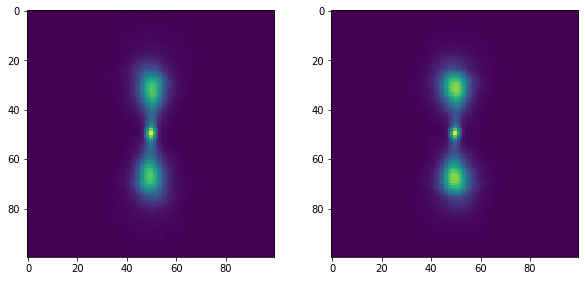

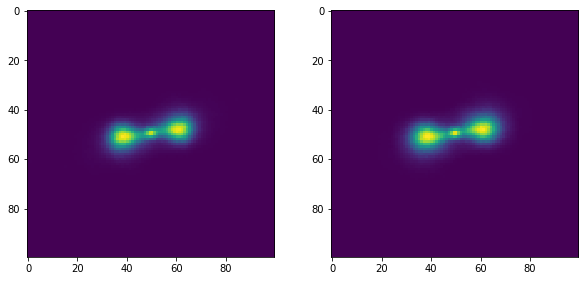

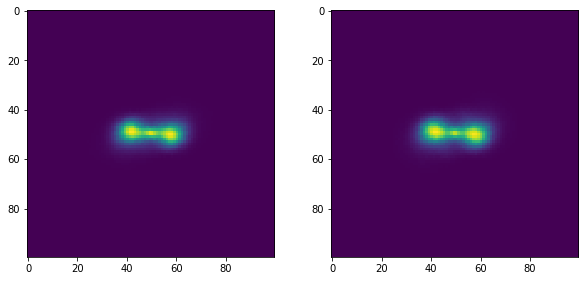

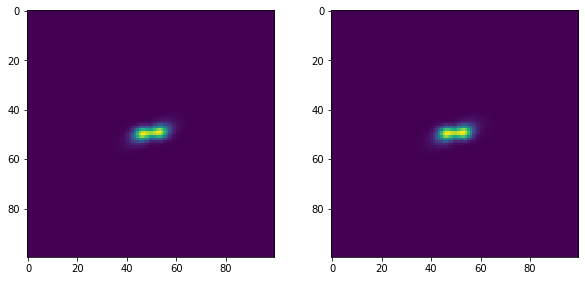

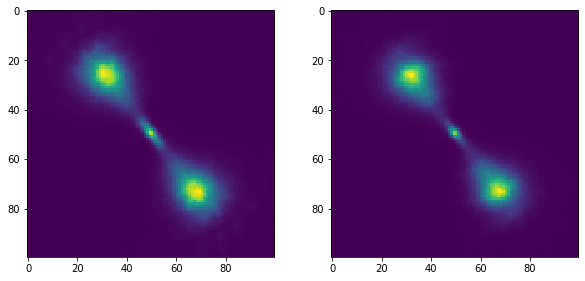

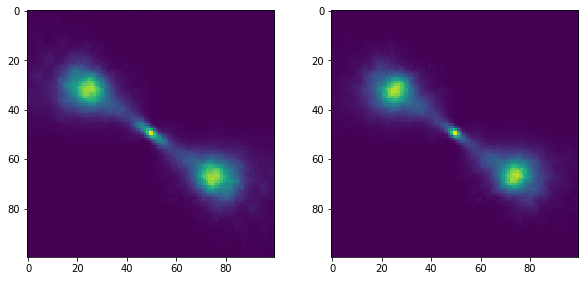

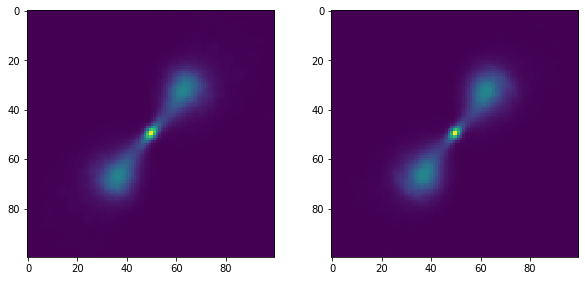

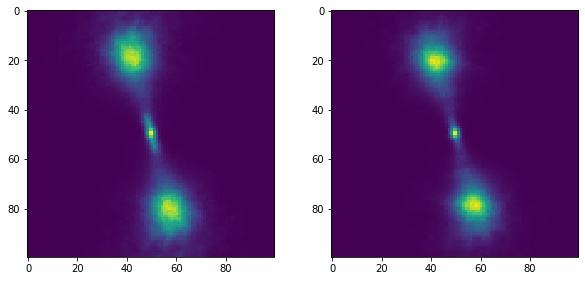

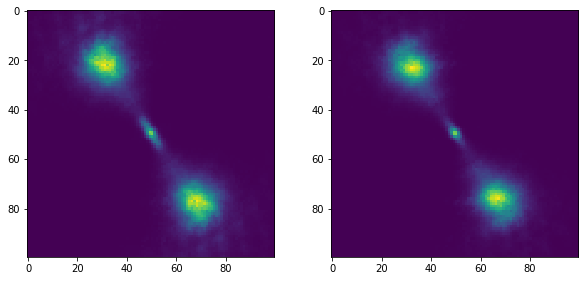

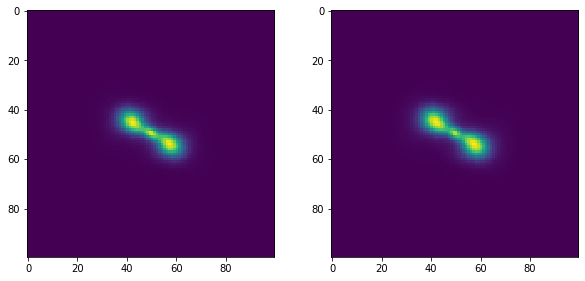

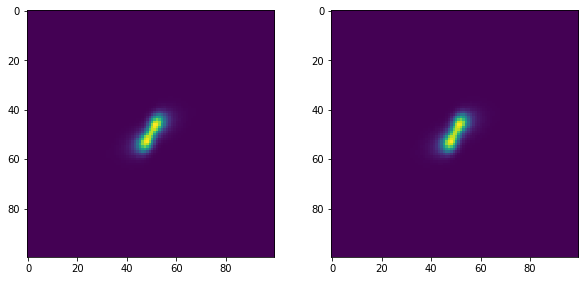

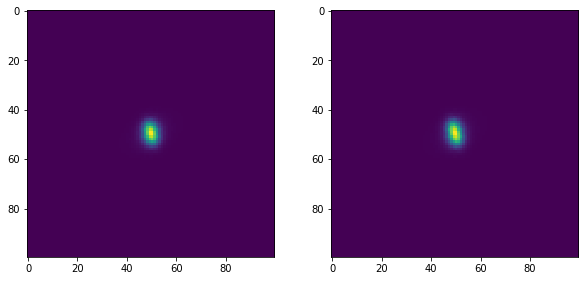

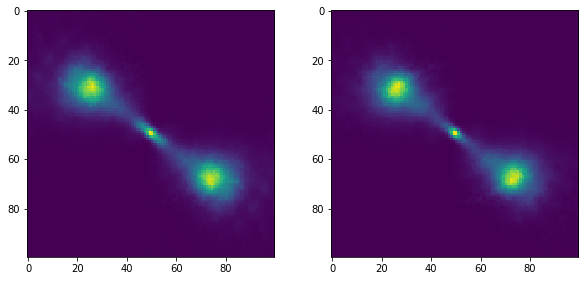

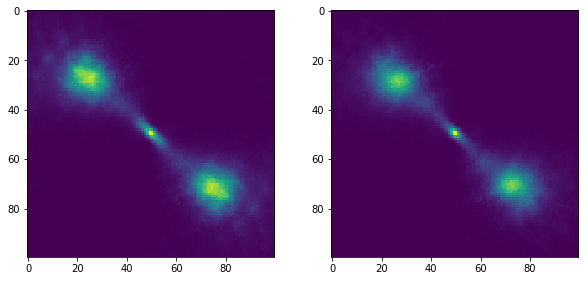

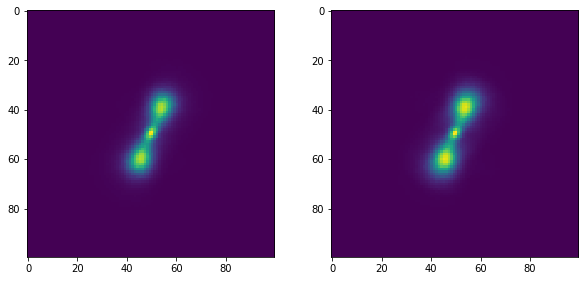

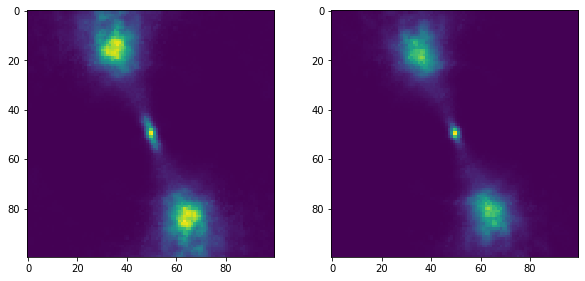

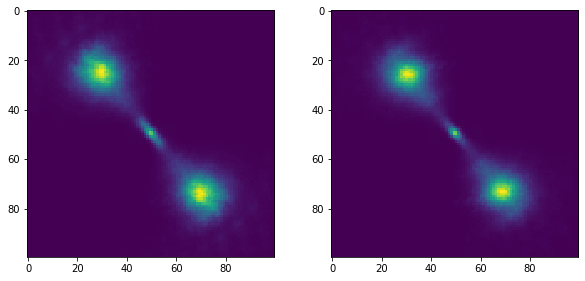

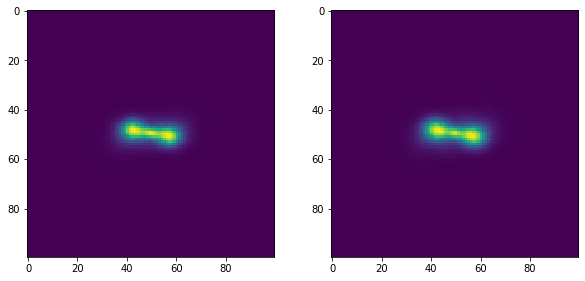

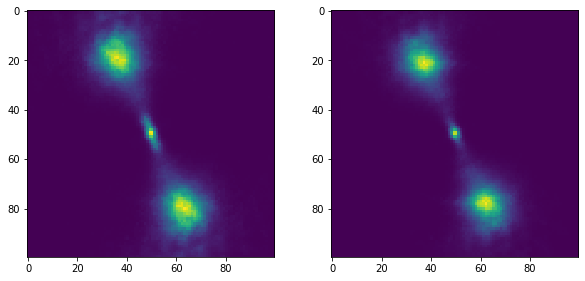

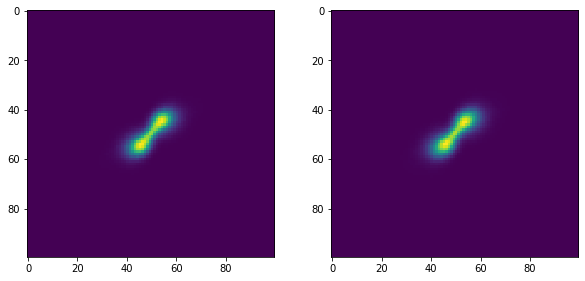

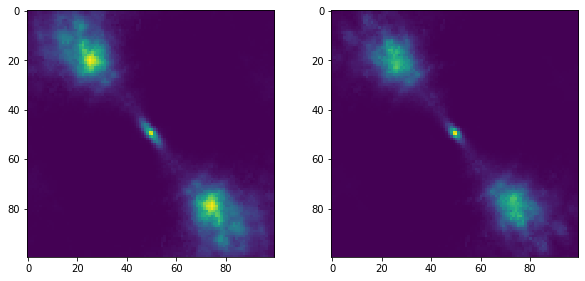

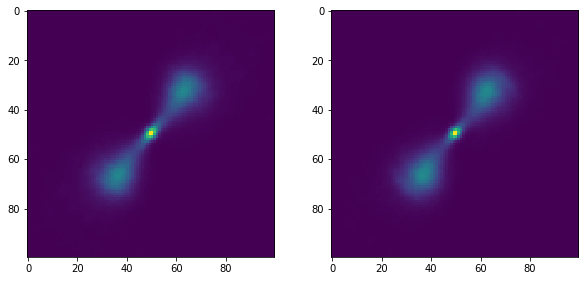

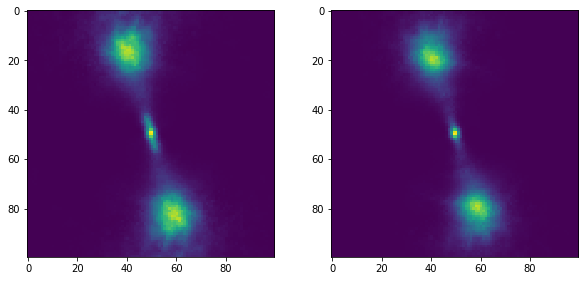

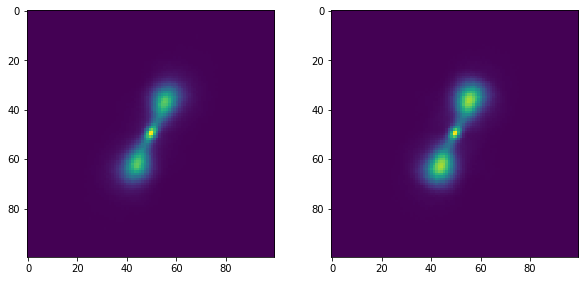

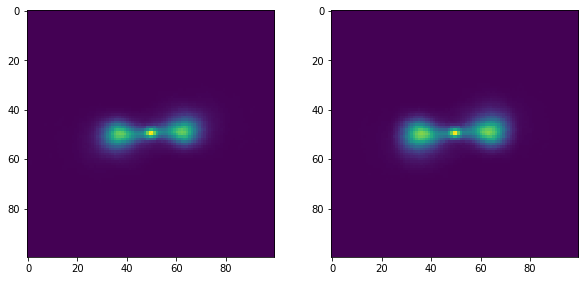

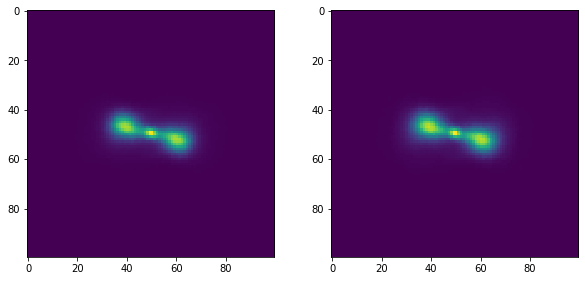

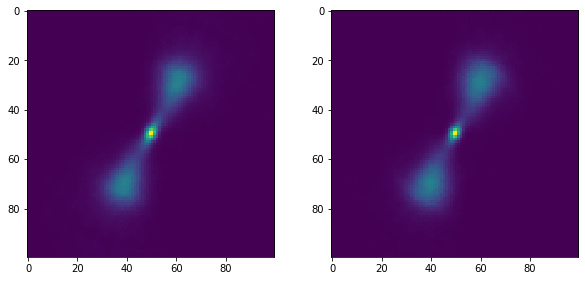

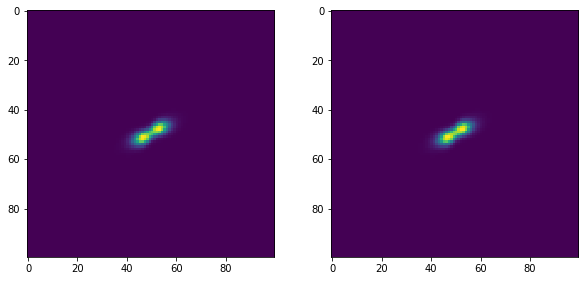

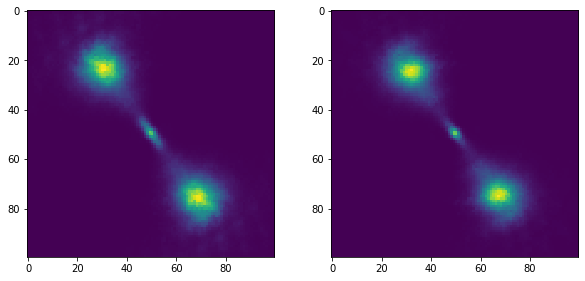

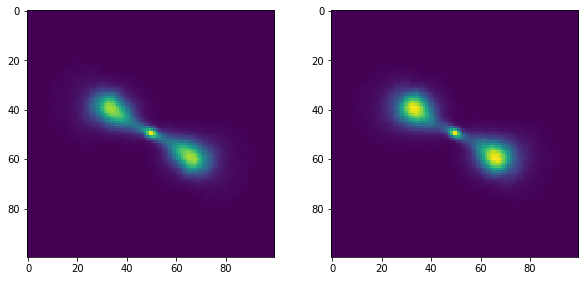

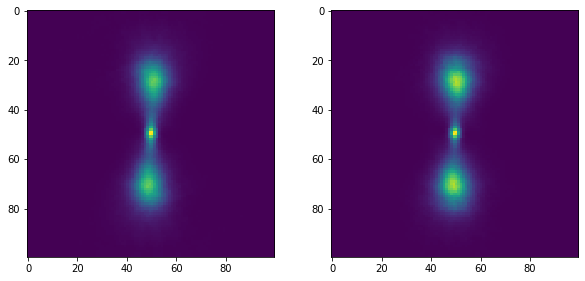

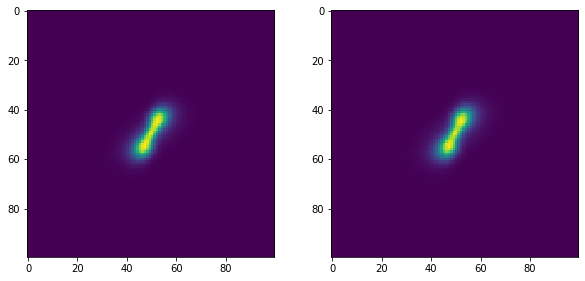

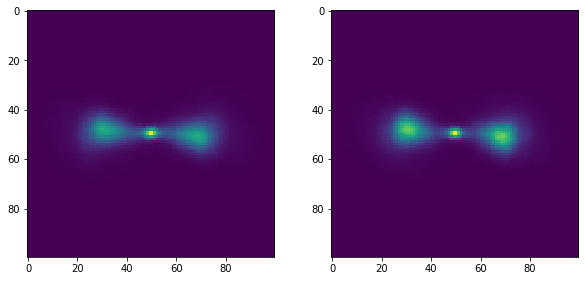

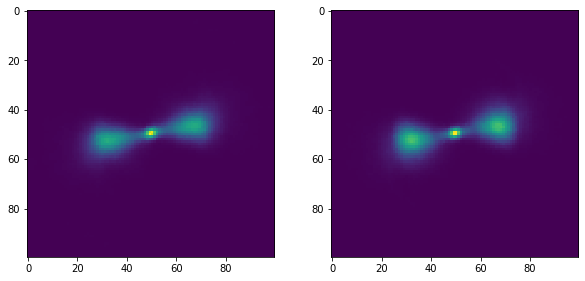

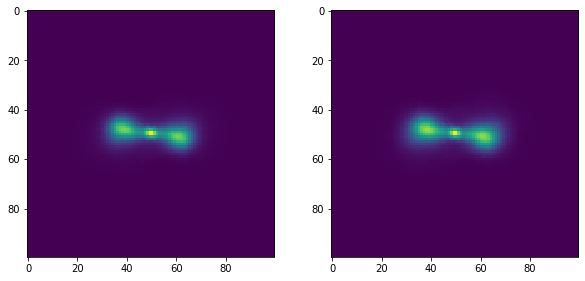

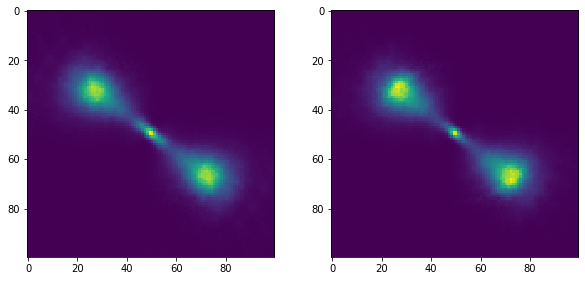

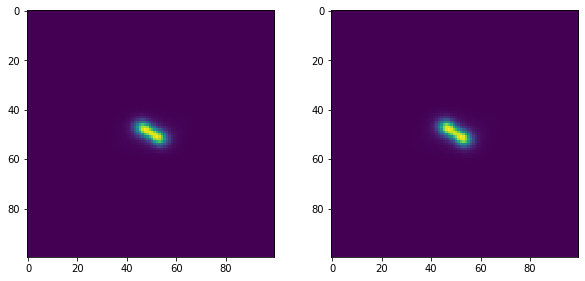

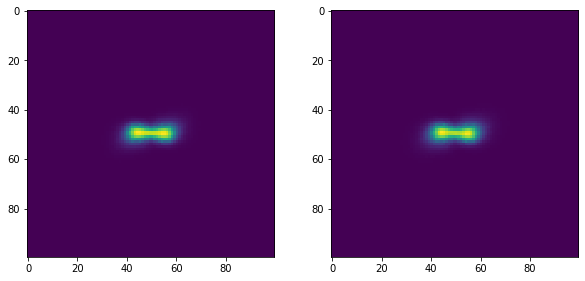

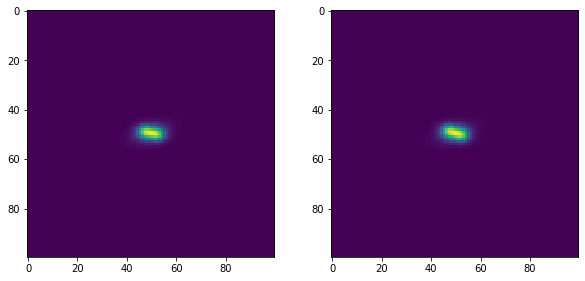

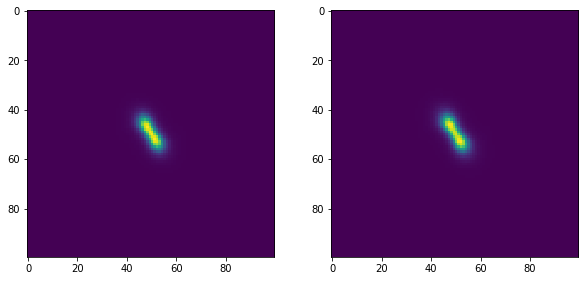

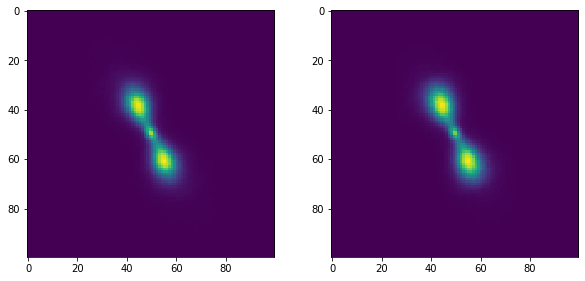

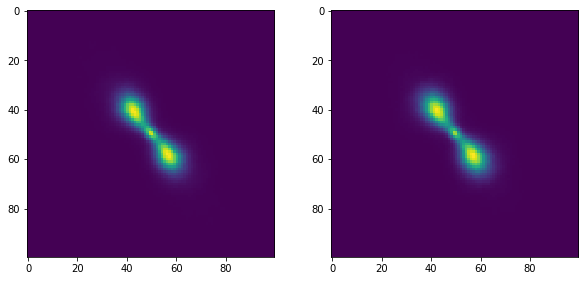

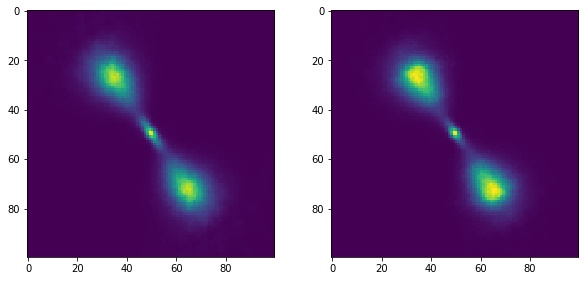

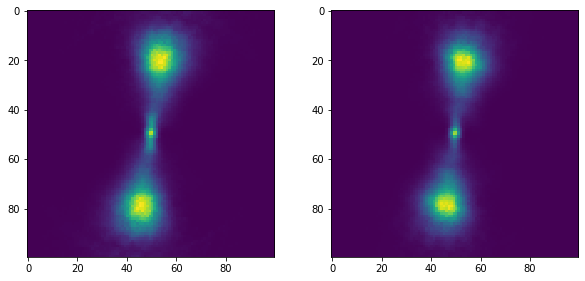

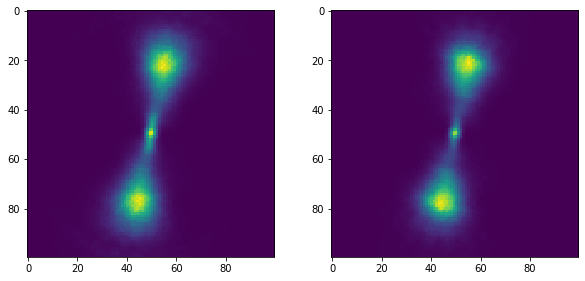

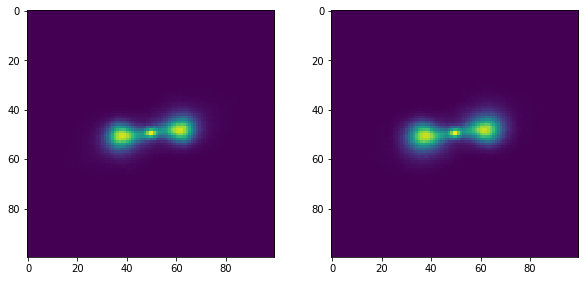

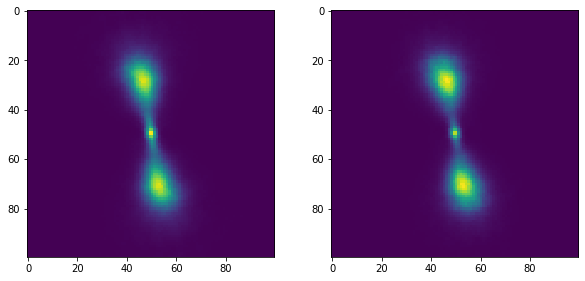

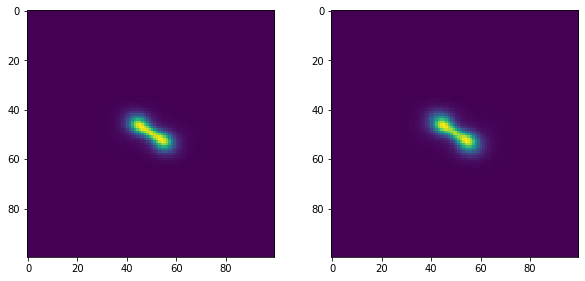

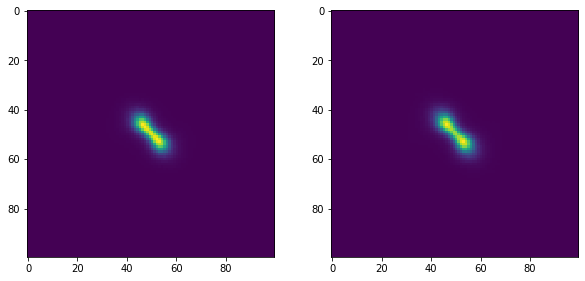

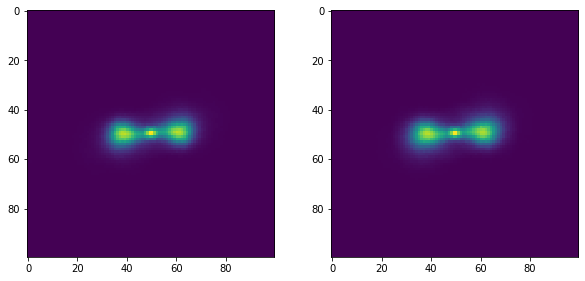

In [54]:
for i in range (0,50):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(sample_fr1[i].reshape(100,100).cpu().detach().numpy())
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(img2[i])
    

In [360]:
import collections

184

16

In [364]:
collections.Counter(array_fr2)

Counter({1.0: 90, 0.0: 10})

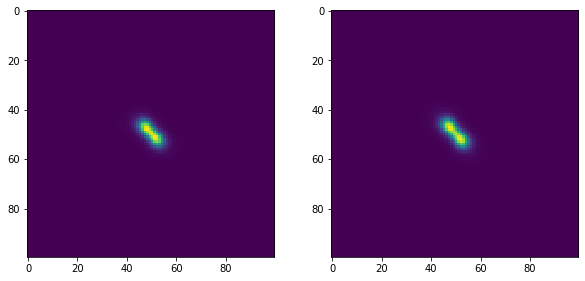

In [386]:
num = 85
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1[num])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2[num])

In [280]:
img_tensor = torch.tensor(np.zeros((1,1,150,150)))
img_tensor[0,0,25:125,25:125]==sample_fr2[i].reshape(100,100)
outputs = net(img_tensor.float())
_, predicted = torch.max(outputs, 1)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1[i])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2[i])

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'other'

In [384]:
# ---------------- Insert Classification Procedure Here ------------------------

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
batch_size_train = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

testset = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=transform) 
batch_size_test = 2
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

classes = ('FRI', 'FRII')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adagrad(net.parameters(), lr=0.01)

nepoch = 200# number of epochs
print_num = 50
for epoch in range(nepoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if i % print_num == (print_num-1):    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / print_num))
            running_loss = 0.0

 
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    correct = 0
    total = 0
    with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50 test images: %d %%' % (100 * correct / total))
    
    array_fr1 = np.zeros(100)
    array_fr2 = np.zeros(100)
    for i in range (0,100):
        img_tensor = torch.tensor(np.zeros((1,1,150,150)))
        img_tensor[0,0,25:125,25:125]=sample_fr2[i].reshape(100,100)
        outputs = net(img_tensor.float())
        _, predicted = torch.max(outputs, 1)

        array_fr2[i]= float(predicted[0].cpu().detach().numpy())

        img_tensor = torch.tensor(np.zeros((1,1,150,150)))
        img_tensor[0,0,25:125,25:125]=sample_fr1[i].reshape(100,100)
        outputs = net(img_tensor.float())
        _, predicted = torch.max(outputs, 1)
    
        array_fr1[i]= float(predicted[0].cpu().detach().numpy())

    print('Number FR1:'+str(collections.Counter(array_fr1)[1]+collections.Counter(array_fr2)[1]))

    print('Number FR2:'+str(collections.Counter(array_fr1)[0]+collections.Counter(array_fr2)[0]))


Files already downloaded and verified
Files already downloaded and verified
[1,    50] loss: 1.610
[1,   100] loss: 0.736
[1,   150] loss: 0.714
[1,   200] loss: 0.720
[1,   250] loss: 0.686
Accuracy of the network on the 50 test images: 56 %
Number FR1:200
Number FR2:0
[2,    50] loss: 0.702
[2,   100] loss: 0.676
[2,   150] loss: 0.617
[2,   200] loss: 0.699
[2,   250] loss: 0.669
Accuracy of the network on the 50 test images: 70 %
Number FR1:199
Number FR2:1
[3,    50] loss: 0.607
[3,   100] loss: 0.598
[3,   150] loss: 0.575
[3,   200] loss: 0.500
[3,   250] loss: 0.537
Accuracy of the network on the 50 test images: 70 %
Number FR1:200
Number FR2:0
[4,    50] loss: 0.461
[4,   100] loss: 0.467
[4,   150] loss: 0.478
[4,   200] loss: 0.478
[4,   250] loss: 0.518
Accuracy of the network on the 50 test images: 78 %
Number FR1:200
Number FR2:0
[5,    50] loss: 0.464
[5,   100] loss: 0.328
[5,   150] loss: 0.366
[5,   200] loss: 0.454
[5,   250] loss: 0.449
Accuracy of the network on th

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


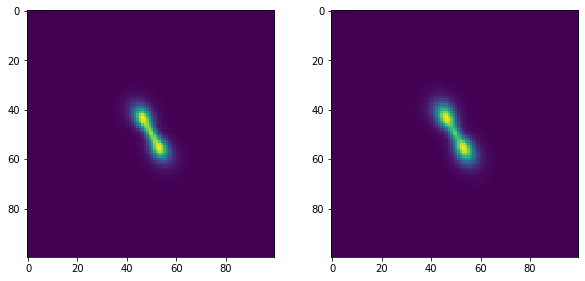

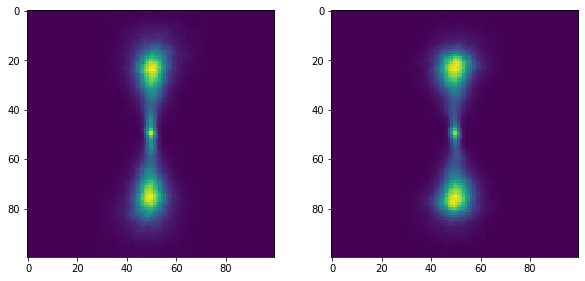

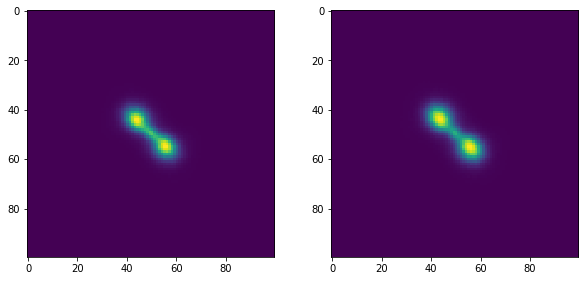

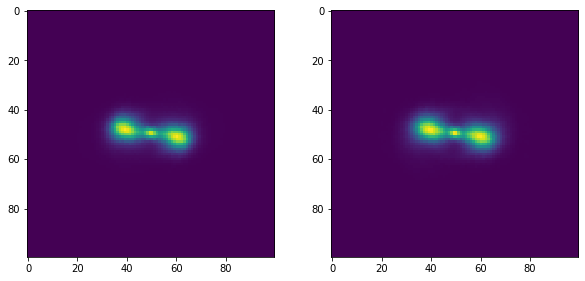

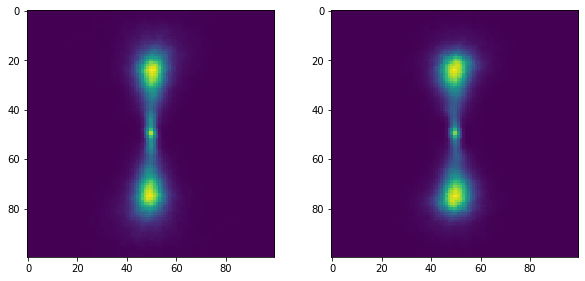

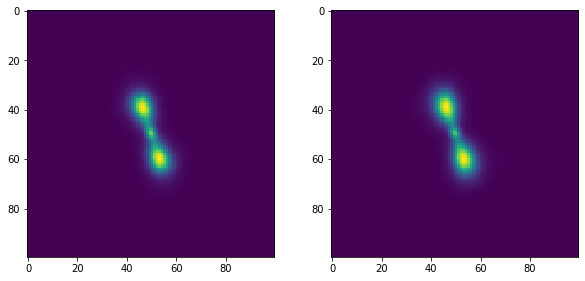

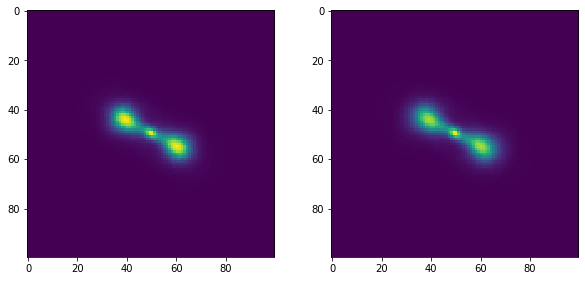

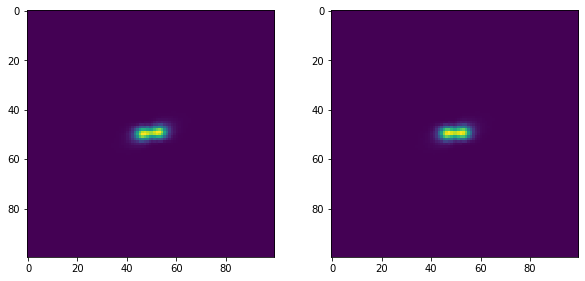

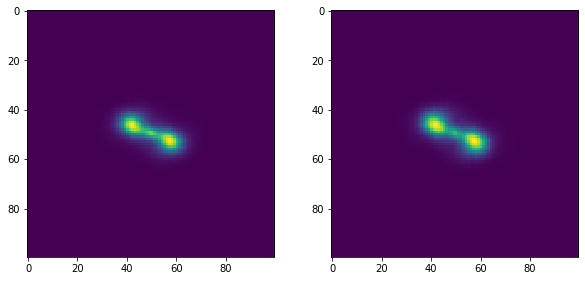

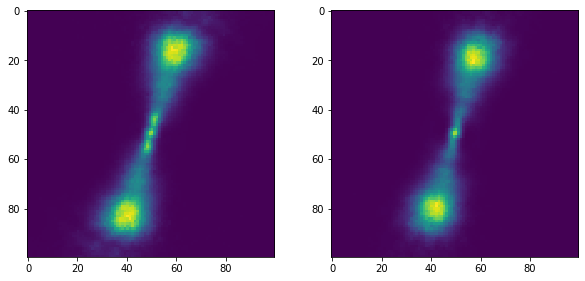

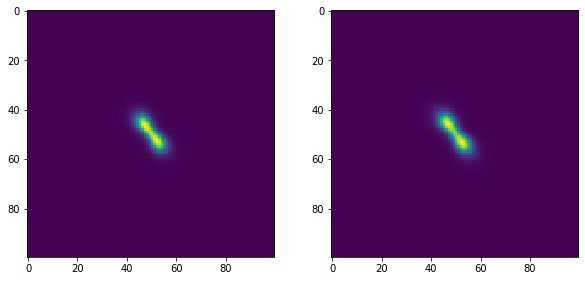

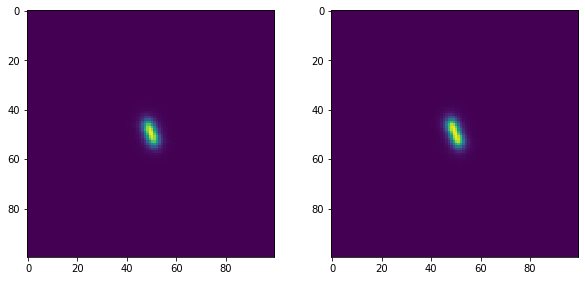

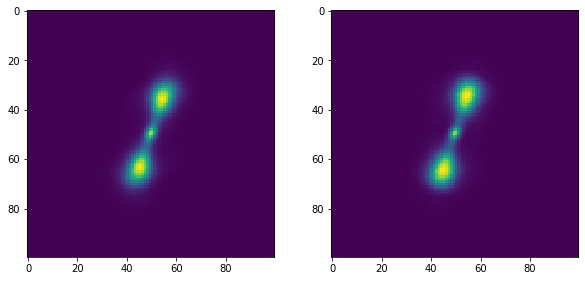

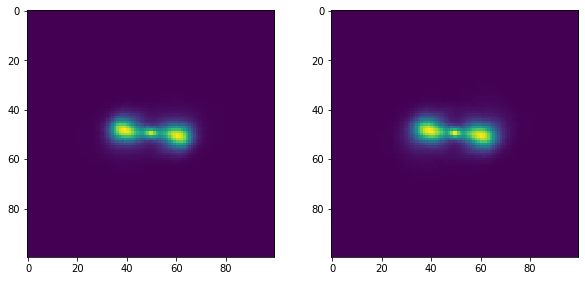

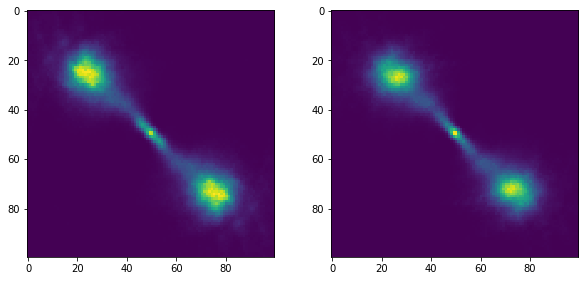

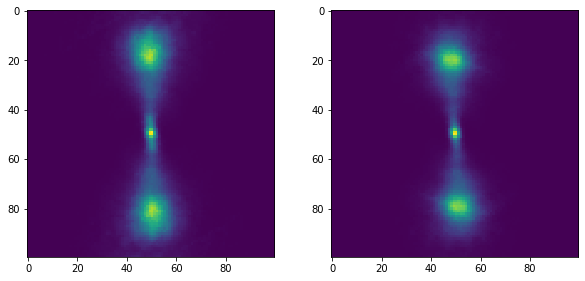

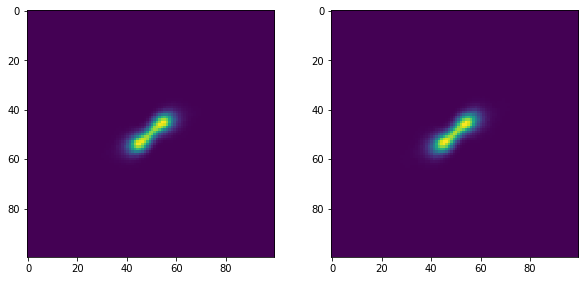

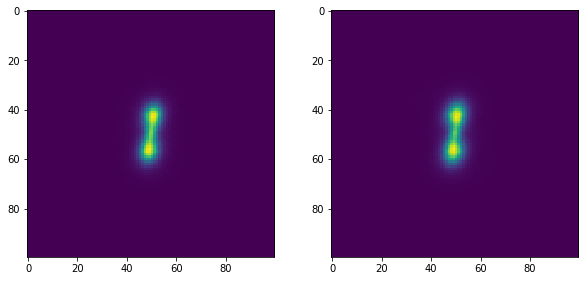

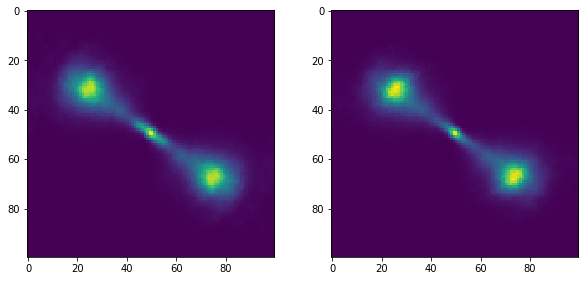

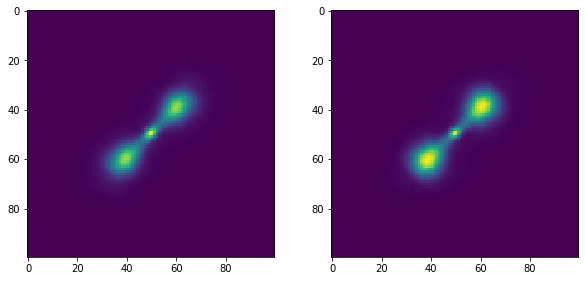

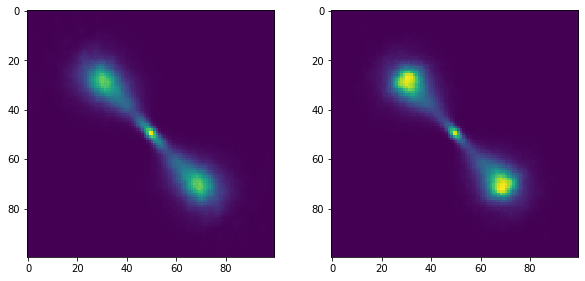

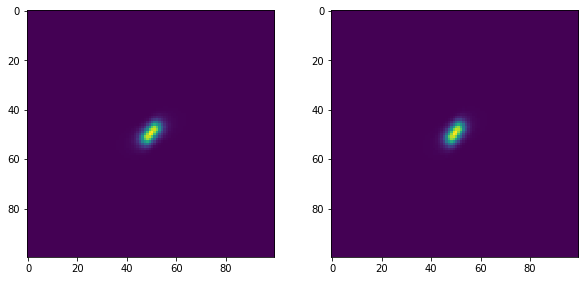

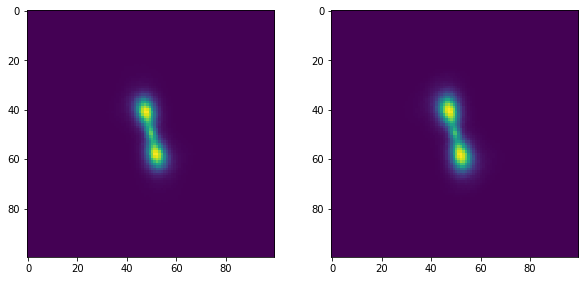

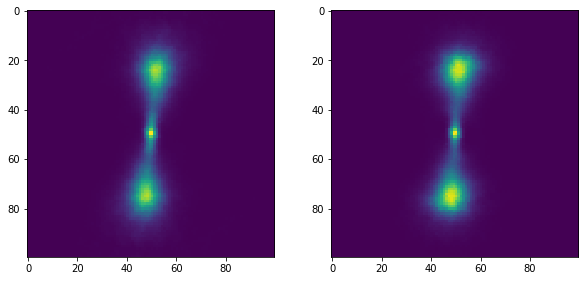

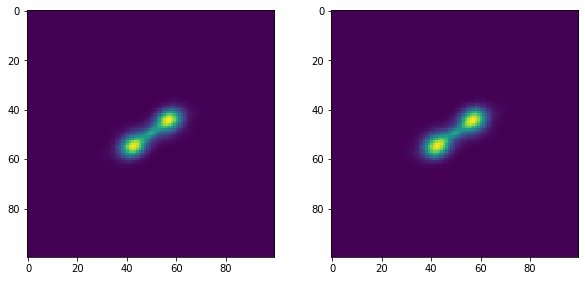

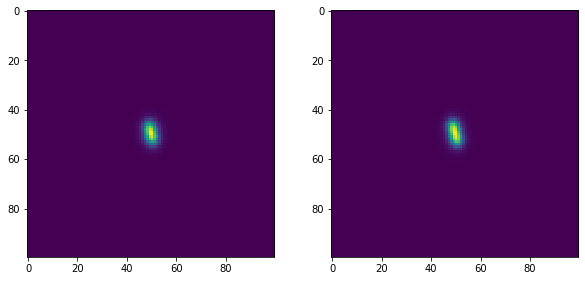

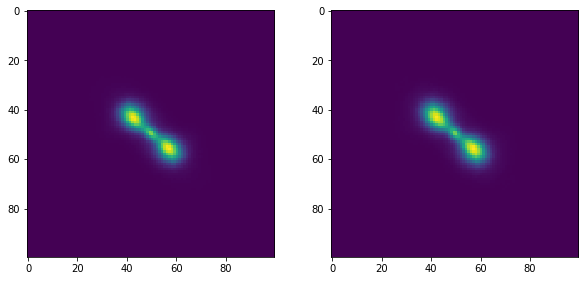

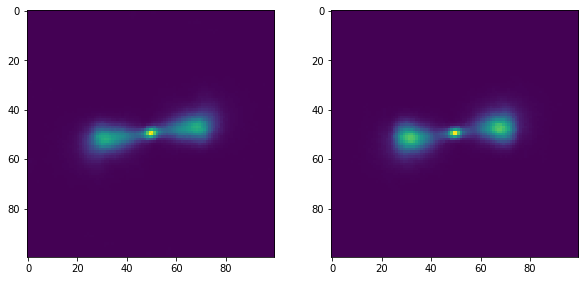

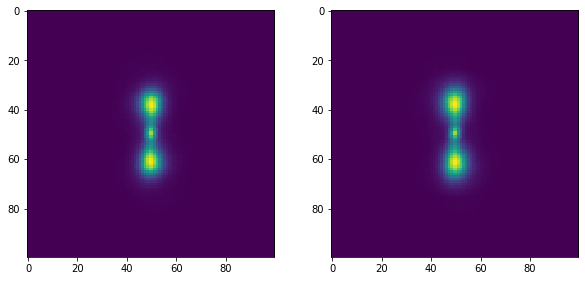

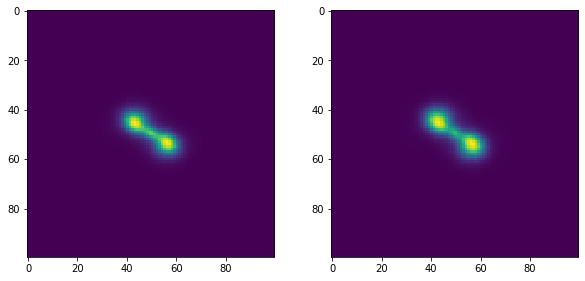

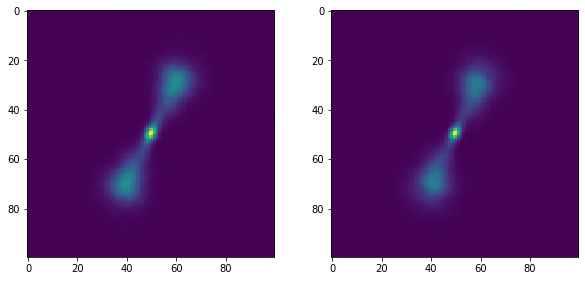

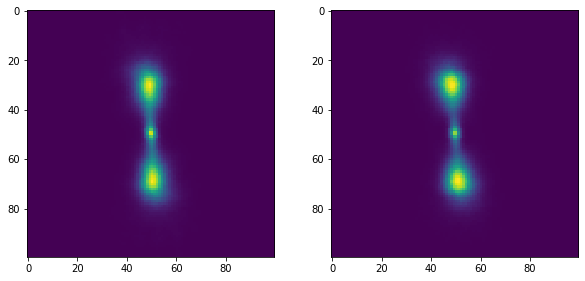

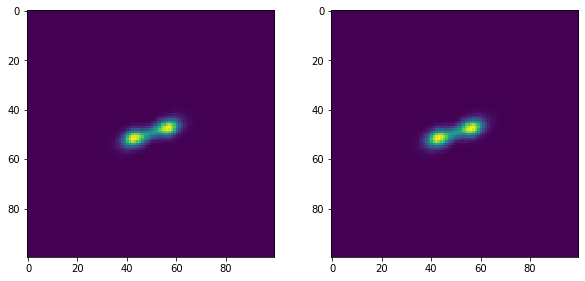

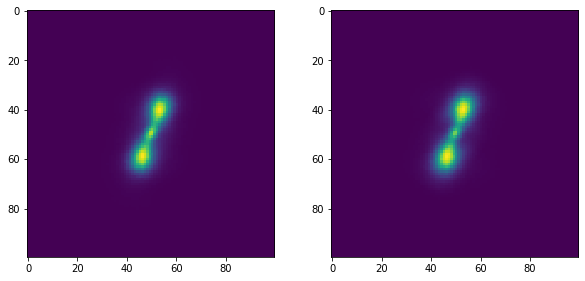

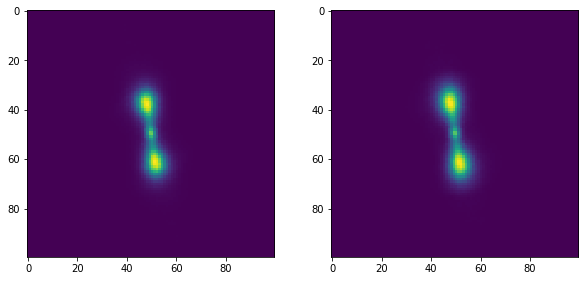

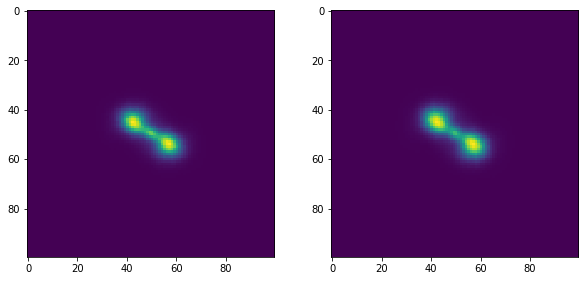

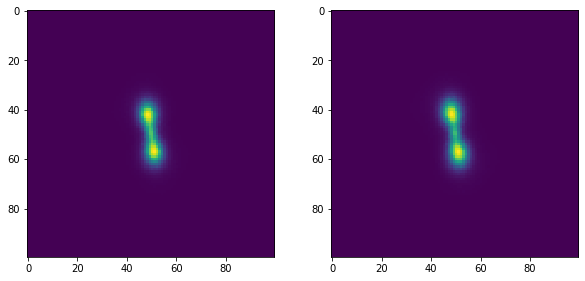

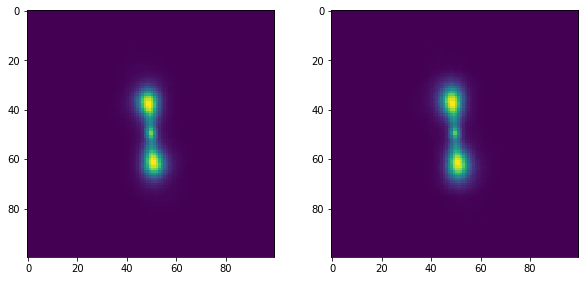

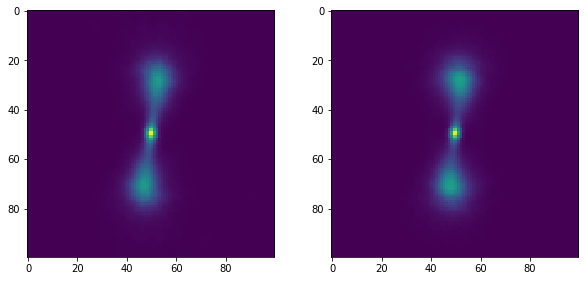

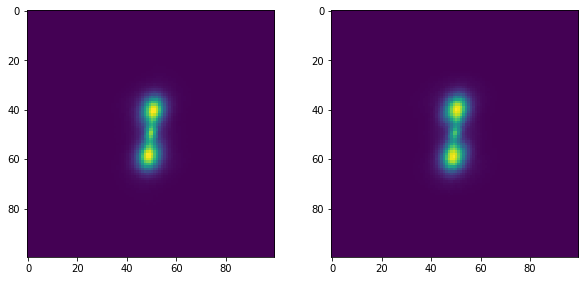

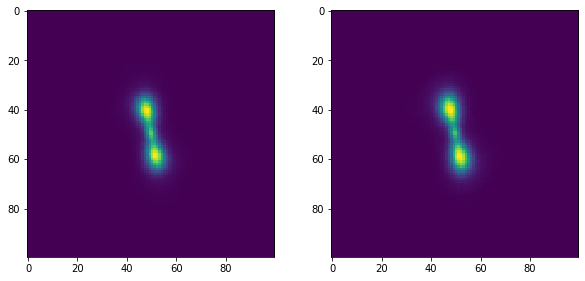

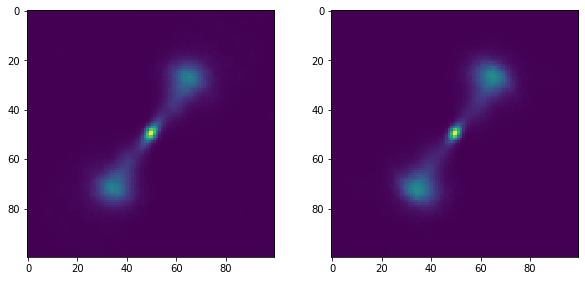

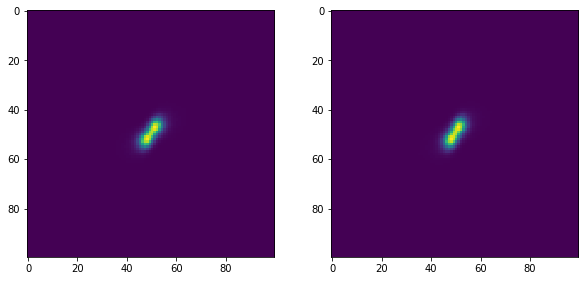

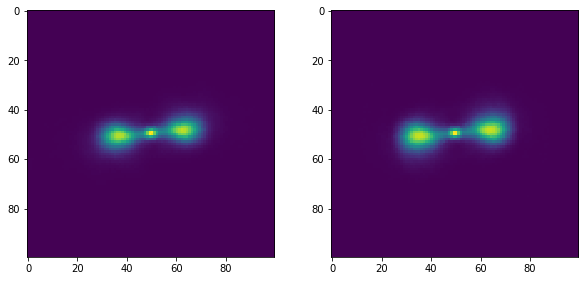

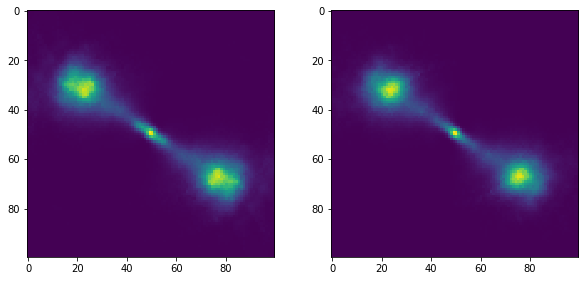

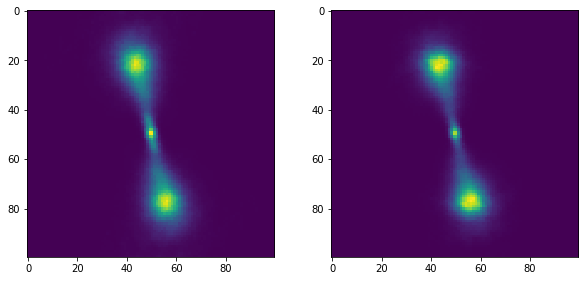

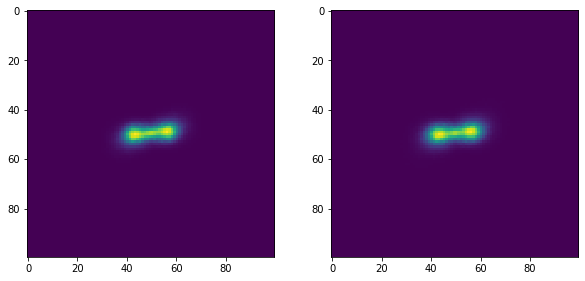

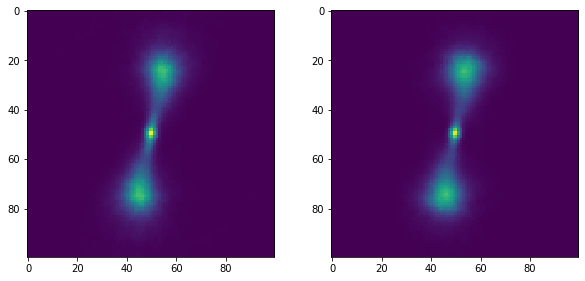

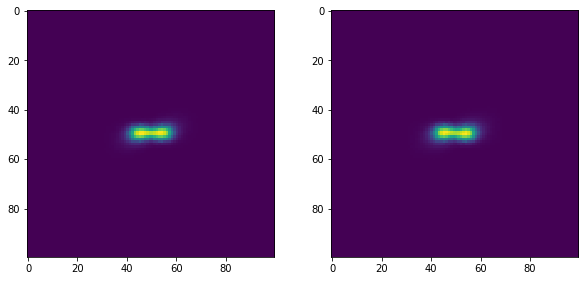

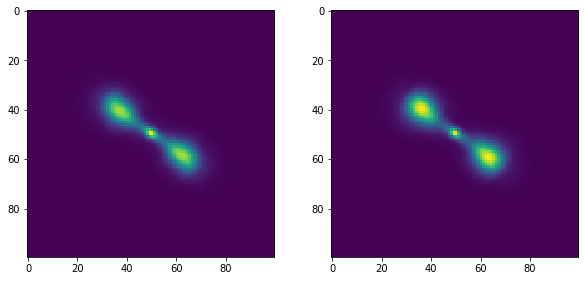

In [382]:
for i in range (0,50):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(sample_fr1[i].reshape(100,100).cpu().detach().numpy())
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(img2[i])
    